In [186]:
import sys; sys.path.append("/Users/dtolpin/venv/stan/lib/python3.7/site-packages/")
import pystan
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

Simulated data:

In [187]:
NUMBER_OF_PAGES = 10
PAGES_PER_SESSION_PRIOR = 5
NUMBER_OF_SESSIONS = 1000

DECAY = 2

# Simulate some trend
TREND = PAGES_PER_SESSION_PRIOR * numpy.exp(- numpy.arange(NUMBER_OF_SESSIONS) * DECAY 
                                            / NUMBER_OF_SESSIONS) 
         

# Sample data around the trend
DATA = numpy.minimum(NUMBER_OF_PAGES,
                          numpy.maximum(1, 
                                        numpy.round(numpy.random.exponential(TREND))))

print("Trend from {:.2f} to {:.2f}".format(TREND[0], TREND[-1]))
print("Data:", DATA)

Trend from 5.00 to 0.68
Data: [ 2.  1.  2.  1.  1.  5.  3.  1.  3.  1.  7. 10.  3.  4. 10.  1.  5.  2.
  1.  2.  3.  2.  1.  4.  3.  4.  3.  1.  1.  4.  2.  3.  1.  3.  7.  5.
  2.  2. 10.  1.  4.  1.  2.  1.  7.  4.  8. 10.  1.  2. 10.  5.  1.  2.
  5.  2.  2.  1.  1. 10.  1.  1.  6.  1. 10.  1.  5.  7.  6.  1. 10.  1.
  3.  3.  9.  2. 10.  7.  5.  5.  2.  7.  6.  6.  3.  4.  4.  4.  9.  1.
  1.  2.  3.  5.  9.  1.  2.  1.  2.  8. 10.  3.  2.  6.  5.  2.  3.  1.
  4.  5.  3.  2.  1.  1.  2.  1.  1.  4.  9.  5.  3.  5.  2.  6. 10.  8.
  4.  5.  3.  9.  7.  1.  5.  2.  5.  5.  1.  1. 10.  8.  3.  6.  5.  4.
  6.  1. 10.  1.  4.  2.  1.  6.  8.  1.  3.  4.  7.  1.  1.  9.  4.  6.
  4.  7.  1.  2.  3.  1.  2.  2.  1.  4.  2.  5.  5.  3.  2.  1.  3.  1.
  1.  2.  4.  1.  6.  1.  3. 10.  1.  1.  2.  2.  1.  2.  2.  1.  2.  1.
  1.  5.  4.  1.  1. 10.  1.  6.  2.  1.  7.  1.  9.  1.  8.  1.  1.  5.
  2.  4.  1.  3.  6.  5.  1.  8.  5.  3.  1.  1.  3.  4.  3.  1.  1.  4.
  1.  2.  2.  1.  3. 

The model in Stan

In [188]:
pps_code = """
data {
    int npages;                // number of pages
    int nsessions;            // number of sessions    
    vector[nsessions] pps;    // page counts (per session)
    real prior_bandwidth;
}

parameters {
    real<lower=0> bandwidth;
}

model {
    // initialize beliefs
    real beliefs[npages, 2];
    real churn_probability = 2. / npages;
    int churned;
    
    for(i in 1:npages) {
        beliefs[i][1] = 2. * churn_probability;
        beliefs[i][2] = 2. * (1 - churn_probability);
    }
    
    // put a prior on the bandwidth
    target += -bandwidth / prior_bandwidth;
    

    for (i in 1:nsessions) {
        for(j in 1:npages) {
            if(j < pps[i]) {
                churned = 0;
            } else {
                churned = 1;
            }

            // observe the pps and update the belief
            {
                real evidence = beliefs[j, 1] + beliefs[j, 2];
                if(churned) {
                    target += log(beliefs[j, 1] / evidence);
                    beliefs[j, 1] += 1;
                } else {
                    target += log(beliefs[j, 2] / evidence);
                    beliefs[j, 2] += 1;
                }

                // discount the beliefs based on the bandwidth
                if(evidence >= bandwidth) {
                    real discount = bandwidth / evidence;
                    beliefs[j, 1] *= discount;
                    beliefs[j, 2] *= discount;
                }
            }
            
            if(churned)
                break;
        }
    }
}
"""

In [189]:
pps_data = {'npages': NUMBER_OF_PAGES,
            'nsessions': NUMBER_OF_SESSIONS,
            'pps': DATA.tolist(),
            'prior_bandwidth': 100}

if False: # enable to rebuild the model
    sm = pystan.StanModel(model_code=pps_code)

Finding the optimum bandwidth:

In [190]:
%%time
optim = sm.optimizing(data=pps_data, as_vector=False,
                      init={'bandwidth': pps_data['prior_bandwidth']})

CPU times: user 4.66 ms, sys: 298 µs, total: 4.96 ms
Wall time: 5.05 ms


In [191]:
print("Best bandwidth: %.6g\nlog-posterior: %.6g" % 
      (optim['par']['bandwidth'], optim['value']))

Best bandwidth: 41.5668
log-posterior: -1390.83


Running the inference:

In [192]:
%%time
fit = sm.sampling(data=pps_data, iter=1000, chains=4)

CPU times: user 23.8 ms, sys: 23.7 ms, total: 47.5 ms
Wall time: 2.09 s


In [193]:
print(fit)

Inference for Stan model: anon_model_2417f640540ab972ddcf0427ba229580.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bandwidth  43.94    0.26   7.79  29.75  38.52  43.36   48.9  59.77    894    1.0
lp__       -1387    0.02   0.68  -1389  -1387  -1387  -1387  -1387    917    1.0

Samples were drawn using NUTS at Sun Nov  4 16:20:46 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Drawing the predicted bandwidth directly through pyplot because `fit.plot()` is buggy and arviz is not working.

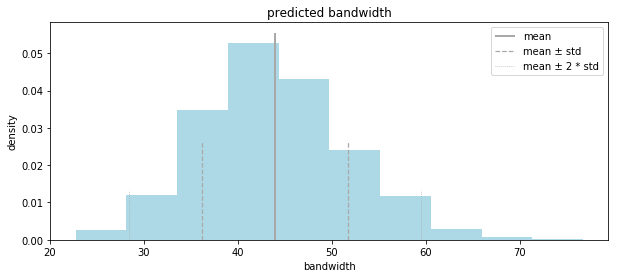

In [194]:
la = fit.extract()
mean, std = la['bandwidth'].mean(), la['bandwidth'].std()
plt.figure(figsize=(10, 4))
plt.title('predicted bandwidth')
plt.xlabel('bandwidth')
plt.ylabel('density')
hist = plt.hist(la['bandwidth'], density=True, color='lightblue')
plt.vlines(ymin=0, ymax=hist[0].max() * 1.05, x=[mean], lw=2, label='mean', color='darkgray')
plt.vlines(ymin=0, ymax=hist[0].max()/2, x=[mean - std, mean+ std],
           lw=1.25, linestyles='dashed', label='mean ± std',
           color='darkgray')
plt.vlines(ymin=0, ymax=hist[0].max()/4, x=[mean - 2 * std, mean + 2 * std], 
           lw=0.75,linestyles='dotted', label='mean ± 2 * std',
           color='darkgray')
plt.legend()